In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
#Load the dataset
df = pd.read_csv('Copper_Set.csv')
df.shape

(181673, 14)

In [ ]:
df.head(10)

In [ ]:
df.columns

# Handling Missing Values

In [4]:
# dealing with data in wrong format,for categorical variables, this step is ignored
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
df['country'] = pd.to_numeric(df['country'], errors='coerce')
df['application'] = pd.to_numeric(df['application'], errors='coerce')
df['thickness'] = pd.to_numeric(df['thickness'], errors='coerce')
df['width'] = pd.to_numeric(df['width'], errors='coerce')
df['material_ref'] = df['material_ref'].str.lstrip('0')
df['product_ref'] = pd.to_numeric(df['product_ref'], errors='coerce')
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [5]:
# converting data which is <=0 into Null
a = df['selling_price'] <= 0
print(a.sum())
df.loc[a, 'selling_price'] = np.nan

a = df['quantity tons'] <= 0
print(a.sum())
df.loc[a, 'quantity tons'] = np.nan

a = df['thickness'] <= 0
print(a.sum())

7
4
0


In [6]:
# FILLING MISSING VALUES WITH Mean/median/mode

df.material_ref.fillna('unknown', inplace=True)

imputer = SimpleImputer(strategy='mean')
df['selling_price'] = imputer.fit_transform(df[['selling_price']])
df['quantity tons'] = imputer.fit_transform(df[['quantity tons']])
df['thickness'] = imputer.fit_transform(df[['thickness']])
df['application'] = imputer.fit_transform(df[['application']])

imputer = SimpleImputer(strategy='median')
df['country']=imputer.fit_transform(df[['country']])



In [ ]:
df.isnull().sum()

In [7]:
df = df.dropna()

In [ ]:
df.isnull().sum()

# Detection of Outliers & Handling them

In [8]:
# Detection of outliers

df1 = df['quantity tons'].copy()

Q1 = df1.quantile(.25) 
Q2 = df1.quantile(.50)
Q3 = df1.quantile(.75)
 
IQR_quantitytons = Q3 - Q1 
print('Interquartile range is', IQR_quantitytons)

Interquartile range is 56.19471486250001


In [9]:
df2 = df['thickness']

Q1 = df2.quantile(.25)
Q2 = df2.quantile(.50)
Q3 = df2.quantile(.75)

IQR_thickness = Q3 - Q1 

print('Interquartile range is', IQR_thickness)

Interquartile range is 2.3


In [10]:
df3 = df['width']
Q1 = df3.quantile(.25)
Q2 = df3.quantile(.50)
Q3 = df3.quantile(.75)

IQR_width = Q3 - Q1
print('Interquartile range is', IQR_width)

Interquartile range is 320.0


In [11]:

df4 = df['selling_price']

Q1 = df4.quantile(.25)
Q2 = df4.quantile(.50)
Q3 = df4.quantile(.75)

 
IQR_selling_price = Q3 - Q1
print('Interquartile range is', IQR_selling_price)


Interquartile range is 284.0


In [14]:
dfr=df.copy()

In [15]:
# Define function to treat outliers using Isolation Forest

def treat_outliers_isolation_forest(dataframe, column):
    clf = IsolationForest(contamination=0.1)  # Contamination is the expected percentage of outliers
    clf.fit(dataframe[[column]])
    outliers = clf.predict(dataframe[[column]])
    dataframe.loc[outliers == -1, column] = None
    

In [16]:
treat_outliers_isolation_forest(dfr, 'quantity tons')

In [17]:
treat_outliers_isolation_forest(dfr, 'thickness')


In [18]:
treat_outliers_isolation_forest(dfr, 'width')

In [19]:
dfr=dfr.dropna()

In [ ]:
dfr.isnull().sum()

In [ ]:
# Visualize Outliers

ax=sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('plot of Outliers in the Given Data')
plt.show()


data=dfr[['quantity tons','thickness','width']]  
plt.title('Plot after dealing with Outliers')
ax=sns.boxplot(data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


# IDENTIFY SKEWNESS & DEALING IT

In [20]:
# Calculate skewness of original data

original_skewness = df[['quantity tons', 'thickness','width', 'selling_price']].skew()
print(original_skewness)


quantity tons    424.677959
thickness        303.439972
width              0.374586
selling_price    301.378963
dtype: float64


In [21]:
# DEALING WITH SKEWNESS
# Log transformation with a small constant
small_constant = 1e-6
df_transformed = df[['quantity tons', 'thickness', 'selling_price','width']] + small_constant
df_transformed = df_transformed.apply(np.log)

# Calculate skewness of transformed columns
skewness_transformed = df_transformed.skew()

print("Skewness of Transformed Columns:")
print(skewness_transformed)

Skewness of Transformed Columns:
quantity tons   -0.067540
thickness        0.351389
selling_price   -5.334034
width           -3.288378
dtype: float64


In [22]:
# Compare skewness measures

skewness_comparison = pd.DataFrame({
    'Original Skewness': original_skewness,
    'Transformed Skewness': skewness_transformed
})

print(skewness_comparison)

               Original Skewness  Transformed Skewness
quantity tons         424.677959             -0.067540
selling_price         301.378963             -5.334034
thickness             303.439972              0.351389
width                   0.374586             -3.288378


# Data Visualization of skewness reduction

In [ ]:
# Plot histograms of original and  transformed columns for skewness
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(df['quantity tons'], bins=20, color='blue', edgecolor='black')
plt.title('Quantity Tons (original)')

plt.subplot(1, 2, 2)
plt.hist(df_transformed['quantity tons'], bins=20, color='blue', edgecolor='black')
plt.title('Quantity Tons (Transformed)')


In [ ]:
# Plots to show reduction of skewness of 'quantity tons'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x=df["quantity tons"])
plt.title('Quantity Tons (original)')

plt.subplot(1, 2, 2)
sns.violinplot(x=df_transformed["quantity tons"])
plt.title('Quantity Tons (Transformed)')
plt.show()

In [ ]:
# displot for quantity tons
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(x=df["quantity tons"])
plt.title('quantity tons (Original)')

plt.subplot(1, 2, 2)
sns.distplot(x=df_transformed["quantity tons"])
plt.title('quantity tons (Transformed)')
plt.show()

In [ ]:
# histogram for thickness
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(df['thickness'], bins=20, color='salmon', edgecolor='black')
plt.title('Thickness (original)')

plt.subplot(1, 2, 2)
plt.hist(df_transformed['thickness'], bins=20, color='salmon', edgecolor='black')
plt.title('Thickness (Transformed)')

In [ ]:
# Plots to show reduction of skewness of 'Thickness'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Thickness (original)')

sns.violinplot(x=df["thickness"])
plt.subplot(1, 2, 2)
sns.violinplot(x=df_transformed["thickness"])
plt.title('Thickness (Transformed)')
plt.show()

In [ ]:
# displot for thickness
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(x=df["thickness"])
plt.title('thickness (Original)')

plt.subplot(1, 2, 2)
sns.distplot(x=df_transformed["thickness"])
plt.title('thickness (Transformed)')
plt.show()

In [ ]:
# histogram plot for thickness
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['selling_price'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Selling Price (Original)')


plt.subplot(1, 2, 2)
plt.hist(df_transformed['selling_price'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Selling Price (Transformed)')
plt.show()


In [ ]:
# Plots to show reduction of skewness of 'selling_price''
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x=df["selling_price"])
plt.title('selling_price (Original)')

plt.subplot(1, 2, 2)
sns.violinplot(x=df_transformed["selling_price"])
plt.title('selling_price (Transformed)')
plt.show()

In [ ]:
# displot for 'selling price'

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(x=df["selling_price"])
plt.title('selling_price (Original)')

plt.subplot(1, 2, 2)
sns.distplot(x=df_transformed["selling_price"])
plt.title('selling_price (Transformed)')
plt.show()
 

In [ ]:
#draw boxplot

ax=sns.boxplot(data = df_transformed)
ax.set_xlabel('criteria')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# Finding Unique Values

In [23]:
dfr['country'] = dfr['country'].astype(str)
country=dfr['country'].unique()
status=dfr['status'].unique()
item=dfr['item type'].unique()
print(country)
print(status)
print(item)

['28.0' '30.0' '32.0' '38.0' '78.0' '27.0' '25.0' '77.0' '113.0' '39.0'
 '40.0' '84.0' '26.0' '80.0' '79.0' '107.0' '89.0']
['Won' 'Draft' 'To be approved' 'Lost' 'Not lost for AM' 'Wonderful'
 'Revised' 'Offered' 'Offerable']
['W' 'S' 'Others' 'PL' 'WI' 'IPL']


# Encode Categorical data

In [24]:
encode=LabelEncoder()
encode_country=encode.fit(country)
transformed_country = encode_country.transform(country)

encode=LabelEncoder()
encode_status=encode.fit(status)
transformed_status = encode_status.transform(status)

encode=LabelEncoder()
encode_item=encode.fit(item)
transformed_item = encode_item.transform(item)

print(transformed_country)
print(transformed_status)
print(transformed_item)

[ 5  6  7  8 12  4  2 11  1  9 10 15  3 14 13  0 16]
[7 0 6 1 2 8 5 4 3]
[4 3 1 2 5 0]


In [25]:
dfr['quantity tons'] = df_transformed ['quantity tons']
dfr['thickness'] = df_transformed['thickness']
dfr['selling_price'] = df_transformed['selling_price']

In [26]:
x=dfr[['quantity tons','application','thickness','width','selling_price','country','customer','product_ref']].corr()

<Axes: >

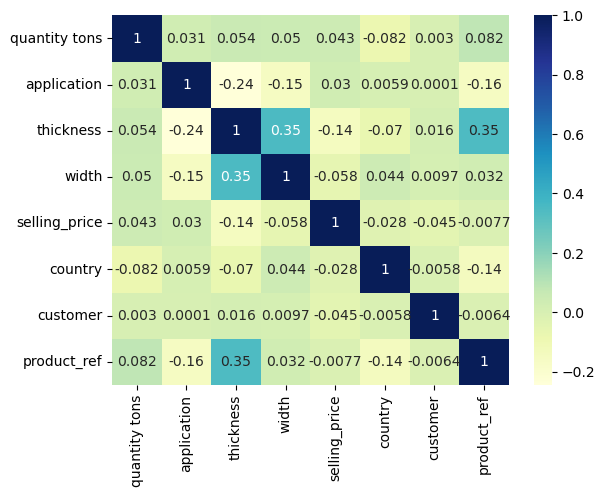

In [27]:
sns.heatmap(x, annot=True, cmap="YlGnBu")

# ML Regression model which predicts continuous variable ‘Selling_Price’

In [50]:


from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['status', 'item type', 'application', 'country', 'customer', 'product_ref']
numerical_cols = ['quantity tons', 'thickness', 'width']

# # Applying OneHotEncoder to categorical columns
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(dfr[categorical_cols])

# encoder1 = OneHotEncoder(handle_unknown='ignore')
# encoder1.fit(X['categorical_cols'])

# Scaling numerical columns
scaler = StandardScaler()
X_num = scaler.fit_transform(dfr[numerical_cols])

# Concatenating encoded categorical and scaled numerical features
X = pd.concat([pd.DataFrame(X_cat.toarray(), columns=encoder.get_feature_names_out(categorical_cols)),
               pd.DataFrame(X_num, columns=numerical_cols)],
              axis=1)

# target variable
y = dfr['selling_price']


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(94726, 1173)
(40597, 1173)
(94726,)
(40597,)


In [32]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, max_depth =20, random_state = 42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test,y_test))

0.9453314915540848
0.9115513910266431


In [33]:
# Calculate y_pred 
y_pred = rf.predict(X_test)
print("y_pred:", y_pred)


y_pred: [6.41454288 6.76901031 6.91349902 ... 6.57941996 6.41829263 6.64822569]


In [34]:
# check metrics for RandomForestRegressor Model
from sklearn import metrics
#check MSE
print("MSE RandomForestRegressor:",metrics.mean_squared_error(y_test,y_pred))
#check MAE
print("MAE RandomForestRegressor:",metrics.mean_absolute_error(y_test, y_pred))


MSE RandomForestRegressor: 0.031466517166241215
MAE RandomForestRegressor: 0.1258156863172716


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 10, learning_rate = 0.1, random_state =42)
gbr.fit(X_train,y_train)
print(gbr.score(X_train,y_train))
print(gbr.score(X_test,y_test))

0.7857793578622322
0.7727594775600023


In [36]:
# Calculate y_pred 
y_pred = gbr.predict(X_test)
print("y_pred:", y_pred)


y_pred: [6.62615405 6.65782329 6.82861923 ... 6.58443263 6.68877877 6.62615405]


In [37]:
# check metrics for GradientBoostingRegressor Model
from sklearn import metrics
#check MSE
print("MSE GradientBoostingRegressor:",metrics.mean_squared_error(y_test,y_pred))
#check MAE
print("MAE GradientBoostingRegressor:",metrics.mean_absolute_error(y_test, y_pred))


MSE GradientBoostingRegressor: 0.0808431911278302
MAE GradientBoostingRegressor: 0.1870099052900458


In [39]:
from sklearn.tree import DecisionTreeRegressor 

dtr = DecisionTreeRegressor(random_state = 42) 
dtr.fit(X_train, y_train)

print(dtr.score(X_train, y_train))
print(dtr.score(X_test,y_test))


1.0
0.8746272255631321


In [40]:
# Calculate y_pred 
y_pred = dtr.predict(X_test)
print("y_pred:", y_pred)

y_pred: [6.23048145 6.74288064 6.93731408 ... 6.51619308 6.46302946 6.69703425]


In [41]:
# check metrics for DecisionTreeRegressor  Model
from sklearn import metrics
#check MSE
print("MSE DecisionTreeRegressor :",metrics.mean_squared_error(y_test,y_pred))
#check MAE
print("MAE DecisionTreeRegressor :",metrics.mean_absolute_error(y_test, y_pred))


MSE DecisionTreeRegressor : 0.044602674985938374
MAE DecisionTreeRegressor : 0.1279252827921638


In [48]:
from sklearn.model_selection import GridSearchCV

dtr = DecisionTreeRegressor()
# hyperparameters
param_grid = {'max_depth': [2, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}
# gridsearchcv
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}


In [52]:
# check metrics for DecisionTreeRegressor  Model
from sklearn import metrics
#check MSE
print("MSE:",metrics.mean_squared_error(y_test,y_pred))
#check MAE
print("MAE :",metrics.mean_absolute_error(y_test, y_pred))
# R2 score
print("R squared error:",metrics.r2_score(y_test,y_pred))

MSE: 0.26844493985424406
MAE : 0.2490544836339324
R squared error: 0.24543344309113457


In [53]:
# Saving the model
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


In [55]:
obj = pd.read_pickle(r'model.pkl')
obj

DecisionTreeRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5)

In [56]:
obj = pd.read_pickle(r'scaler.pkl')
obj

StandardScaler()

In [57]:
obj = pd.read_pickle(r'encoder.pkl')
obj

OneHotEncoder()

In [ ]:
import pickle

# Load the trained model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler and encoder if needed
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Predict selling price
predicted_selling_price = loaded_model.predict(new_data)

# Print the predicted selling price
print("Predicted selling price:", predicted_selling_price)


# Classifier ML

In [98]:
df.status.value_counts()

status
Won                116005
Lost                34436
Not lost for AM     19573
Revised              4276
To be approved       4168
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

In [106]:
dfc = dfr.copy()

In [107]:
dfc = dfr[dfr['status'].isin(['Won', 'Lost'])]
# dfc
# len(dfc)
# dfc.head(10)
# dfc.shape

In [108]:
dfr['item type'].unique()

array(['W', 'S', 'Others', 'PL', 'WI', 'IPL'], dtype=object)

In [110]:
#use ordinal encoder to convert categorical data into numerical data
OE = OrdinalEncoder()
dfc.status = OE.fit_transform(dfc[['status']])
dfc['item type'] = OE.fit_transform(dfc[['item type']])
dfc['country'] = OE.fit_transform(dfc[['country']])

In [114]:
X = dfc[['quantity tons','selling_price','item type','application','thickness','width','country','customer','product_ref']]
y = dfc['status']

In [115]:
SS = StandardScaler()
SS.fit_transform(X)

array([[ 0.76344104,  0.18057105,  0.71355638, ..., -0.53438342,
        -0.01242751,  1.66782743],
       [ 1.38206396,  0.5452215 ,  0.71355638, ..., -0.06769   ,
         0.00833988, -0.67081741],
       [ 0.96715869,  2.15534609, -1.12288978, ...,  0.16565671,
         0.00825453,  1.66489058],
       ...,
       [ 1.33183416, -1.29645336,  0.71355638, ..., -1.23442356,
        -0.00745072, -0.44183844],
       [ 1.29742178, -1.37435009,  0.71355638, ..., -1.23442356,
        -0.00745072, -0.44183844],
       [-1.36964103, -1.17882394,  0.71355638, ..., -1.23442356,
        -0.00745072, -0.44183844]])

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(78346, 9)
(33577, 9)
(78346,)
(33577,)


In [117]:
dfc.shape

(111923, 14)

In [118]:
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import ExtraTreesClassifier

In [120]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
print(LR.score(X_train, y_train))
print(LR.score(X_test, y_test))

0.783371199550711
0.7846144682371862


In [121]:
xgb_model = XGBClassifier(objective="binary:logistic",random_state=42) 

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

print(xgb_model.score(X_train,y_train))
print(xgb_model.score(X_test,y_test))
# # Evaluate the model's performance on the training data
# train_score = xgb_model.score(X_train, y_train)
# print("Training accuracy score:", train_score)

0.9197916932581115
0.8993656371921256


In [130]:
print("y_predict of xgb:",  xgb_model.predict(X_test))


y_predict of xgb: [0 0 1 ... 1 1 1]


In [131]:
print("MSE of xgb:", mean_squared_error(y_test, y_predict))

MSE of xgb: 0.10063436280787444


In [141]:
clf = ExtraTreesClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred= clf.predict(X_test)
print("MSE of clf:", mean_squared_error(y_test, y_pred))

1.0
0.9218214849450517
[0. 0. 0. ... 1. 1. 1.]
MSE of clf: 0.07817851505494833


In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 5859,  1373],
       [ 1252, 25093]], dtype=int64)

Text(58.222222222222214, 0.5, 'Truth')

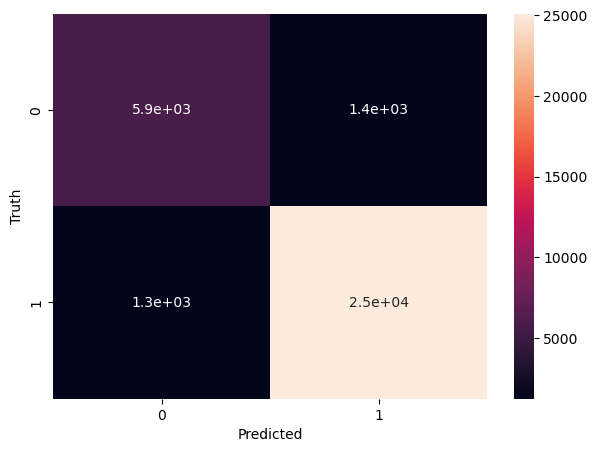

In [143]:
#draw heatmap
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [145]:
# from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix,classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[ 5859,  1373],
       [ 1252, 25093]], dtype=int64)

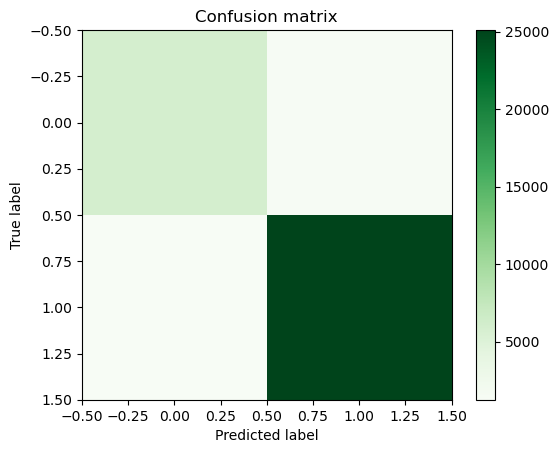

In [151]:
# plot_confusion_matrix(knn, X_test, y_test);

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

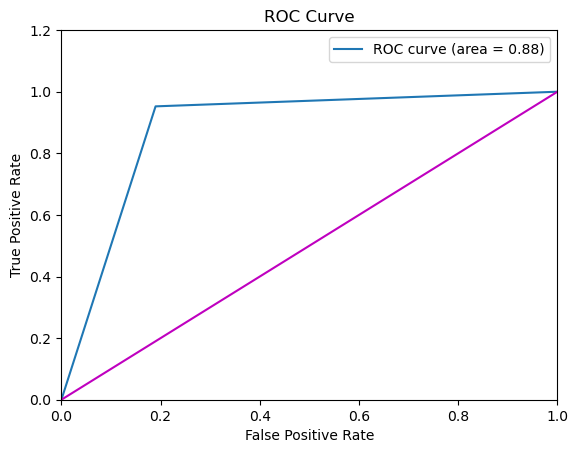

In [153]:
# ROC curve and AUC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'm-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [157]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.82      7232
         1.0       0.95      0.95      0.95     26345

    accuracy                           0.92     33577
   macro avg       0.89      0.88      0.88     33577
weighted avg       0.92      0.92      0.92     33577



In [155]:
# Saving the model
import pickle
with open('OE.pkl', 'wb') as file:
    pickle.dump(OE, file)
with open('SS.pkl', 'wb') as f:
    pickle.dump(SS, f)
with open('LR.pkl', 'wb') as f:
    pickle.dump(LR, f)
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)
